# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [ ]:
#!pip install ipywidgets

import subprocess
import sys
import ipywidgets

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(torch.__version__)

1.11.0+cu102


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [55]:
bs = 64

# Establish our transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create training set and define training dataloader
training_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Create test set and define test dataloader
train_loader = DataLoader(training_data, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_data, batch_size=bs, shuffle=True)

## Justify your preprocessing

ToTensor() converts an image to tensor, so it is the correct transformer to use. Normalization is also required for the images, however since the images are grayscale only one value is required for mean and std (the input array for each is len 3 to allow for a value for each color channel). 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [56]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Index: 1
Type: <class 'torch.Tensor'>
Size: torch.Size([1, 28, 28])
0


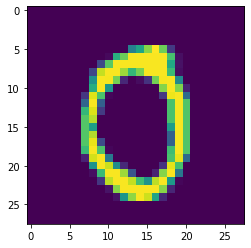

5


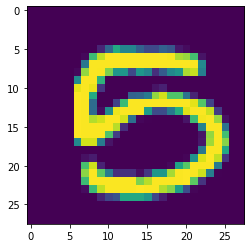

0


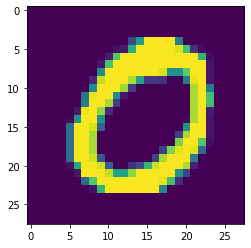

6


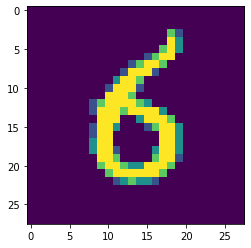

1


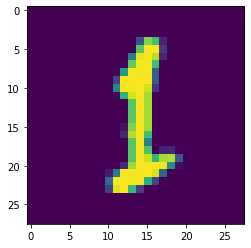

In [57]:
# Explore data -- understanding image size, type ++ using show5 to view examples
def img_metadata(loc):
    img, lab = training_data[loc]
    print('Index:', loc)
    print('Type:', type(img))
    print('Size:', img.size())

img_metadata(1)
    
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [58]:
# Define the class for your neural network
# Define the class for your neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        self.activation = nn.Sigmoid()
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.cnn2 = nn.Conv2d(16, 32, 5, 1, 2)
        
        self.mp = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(6272, 10)
        self.fc2 = nn.LogSoftmax(dim=1)'''
        
        self.cnn1 = nn.Conv2d(1, 20, 5, 1)
        self.cnn2 = nn.Conv2d(20, 50, 5, 1)
        self.activation = nn.Sigmoid()
        self.fc1 = nn.Linear(4*4*50, 256)
        self.fc2 = nn.Linear(256, 10)
        self.fc3 = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        
        x = F.relu(self.cnn1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.cnn2(x))
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x)) 
        x = self.fc3(x)

        return x

# Instantiate the model
net = Net()

if torch.cuda.is_available():
    net.cuda()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 10

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [60]:
training_loss_history = []
validation_loss_history = []

for epoch in range(epochs):
    
    net.train()
    
    training_loss = 0
    training_correct = 0
    
    for i, data in enumerate(train_loader): # training loop
        
        inputs, labels = data
        
        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        fwd_outputs = net(inputs)
        
        loss = criterion(fwd_outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(fwd_outputs.data, 1)
        
        training_loss += loss.item()
        training_correct += (pred == labels).sum().item()
        
    training_loss_history.append(training_loss/len(train_loader))
    print(f'Epoch {epoch + 1} training accuracy: {training_correct/len(train_loader):.2f}% training loss: {training_loss/len(train_loader):.5f}')
        
    validation_loss = 0
    validation_correct = 0
    
    net.eval()
          
    for inputs, labels in test_loader:
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, pred = torch.max(outputs.data, 1)

        validation_loss += loss.item()
        validation_correct += (pred == labels).sum().item()
          
    validation_loss_history.append(validation_loss/len(test_loader)) 
    print(f'Epoch {epoch + 1} validation accuracy: {validation_correct/len(test_loader):.2f}% validation loss: {validation_loss/len(test_loader):.5f}')

Epoch 1 training accuracy: 60.45% training loss: 1.54209
Epoch 1 validation accuracy: 62.71% validation loss: 1.48011
Epoch 2 training accuracy: 63.07% training loss: 1.47668
Epoch 2 validation accuracy: 62.87% validation loss: 1.47367
Epoch 3 training accuracy: 63.34% training loss: 1.47135
Epoch 3 validation accuracy: 63.13% validation loss: 1.46993
Epoch 4 training accuracy: 63.47% training loss: 1.46863
Epoch 4 validation accuracy: 63.13% validation loss: 1.46978
Epoch 5 training accuracy: 63.57% training loss: 1.46726
Epoch 5 validation accuracy: 63.10% validation loss: 1.46987
Epoch 6 training accuracy: 63.65% training loss: 1.46613
Epoch 6 validation accuracy: 63.15% validation loss: 1.46959
Epoch 7 training accuracy: 63.71% training loss: 1.46528
Epoch 7 validation accuracy: 63.29% validation loss: 1.46745
Epoch 8 training accuracy: 63.74% training loss: 1.46461
Epoch 8 validation accuracy: 63.15% validation loss: 1.46857
Epoch 9 training accuracy: 63.75% training loss: 1.46439

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
## YOUR CODE HERE ##
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##